In [1]:
import os
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from skimage.io import ImageCollection, imsave
from skimage.color import rgb2hsv, rgb2gray, gray2rgb
from skimage.transform import resize, warp, SimilarityTransform, AffineTransform, ProjectiveTransform
from skimage.feature import (ORB, match_descriptors, corner_harris, corner_peaks, BRIEF,)
from skimage.measure import ransac
from skimage.util import img_as_float
from numpy.random import randint
from skimage.data import imread

from skimage.measure import label
from skimage.graph import route_through_array
from sklearn.feature_extraction import image
from subprocess import Popen, PIPE
from multiprocessing import Pool, freeze_support, cpu_count
import itertools
from scipy.ndimage import rotate
import math
%matplotlib inline
path_to_enblend = '/Users/jhansen/Applications/enblend-enfuse-4.0-mac/enblend'
tmp_out = '/tmp/out.png'
tmp_base = '/tmp/base.png'
tmp_img = '/tmp/img.png'
data_dir = '../data/jpg/'



rsn = 4

In [2]:

def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches, title='',
                 keypoints_color='b', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1 = img_as_float(image1)
    image2 = img_as_float(image2)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))
    ax.set_title(title)

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3, 1)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]),
                '-', color=color)



In [3]:
run='texture'
test_imgs = {'texture':['dsc04743.jpg', 'dsc04744.jpg'], 
            'minimal':['dsc02820.jpg', 'dsc02821.jpg']}

img1o = imread(test_imgs[run][0])[0]#[:,:,2]
img2o = imread(test_imgs[run][1])[0]#[:,:,2]


In [4]:
img1o.shape

(4000, 6000, 3)

In [5]:
num_keypoints = 100

(57, 0.77)
(100, 1.0)
(98, 0.27)


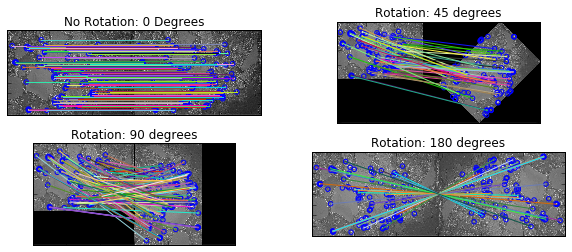

In [63]:
img1 = resize(rgb2gray(img1o), (400,600))

ph = -img1.shape[0]
pw = -img1.shape[1]
ftype = 'ORB'


imgt = img1 
img45 = rotate(imgt, 45)
img90 = rotate(imgt, 90)
img180 = rotate(imgt, 180)

descriptor_extractor = ORB(n_keypoints=num_keypoints)

descriptor_extractor.detect_and_extract(imgt)
keypoints = descriptor_extractor.keypoints
descriptors = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(imgt)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img45)
keypoints45 = descriptor_extractor.keypoints
descriptors45 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img90)
keypoints90 = descriptor_extractor.keypoints
descriptors90 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img180)
keypoints180 = descriptor_extractor.keypoints
descriptors180 = descriptor_extractor.descriptors


if True:
    matches = match_descriptors(descriptors, descriptors1, cross_check=True)
    matches45 = match_descriptors(descriptors, descriptors45, cross_check=True)
    matches90 = match_descriptors(descriptors, descriptors90, cross_check=True)
    matches180 = match_descriptors(descriptors, descriptors180, cross_check=True)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,4))

    plt.gray()
    # Select keypoints from 
    #   * source (image to be registered)
    #   * target (reference image): 
    src = keypoints[matches[:, 0]][:, ::-1]
    dst = keypoints1[matches[:, 1]][:, ::-1]
    
    model_robust, inliers = ransac((src, dst), AffineTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300, 
                                      stop_probability=.99)

    
    
    src45 = keypoints[matches45[:, 0]][:, ::-1]
    dst45 = keypoints45[matches45[:, 1]][:, ::-1]

    model_robust45, inliers45 = ransac((src45, dst45), AffineTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300, 
                                      stop_probability=.99)

    src90 = keypoints[matches90[:, 0]][:, ::-1]
    dst90 = keypoints90[matches90[:, 1]][:, ::-1]

    model_robust90, inliers90 = ransac((src90, dst90), AffineTransform,
                                       min_samples=4, residual_threshold=.5, max_trials=300, 
                                      stop_probability=.99)
    
    src180 = keypoints[matches180[:, 0]][:, ::-1]
    dst180 = keypoints90[matches180[:, 1]][:, ::-1]

    model_robust180, inliers180 = ransac((src180, dst180), AffineTransform,
                                       min_samples=4, residual_threshold=.5, max_trials=300, 
                                      stop_probability=.99)
    
    ransac_matches = matches[inliers]
    ransac_matches45 = matches45[inliers45]
    ransac_matches90 = matches90[inliers90]
    ransac_matches180 = matches180[inliers180]
    prec = round(ransac_matches.shape[0]/float(matches.shape[0]), 2)
    prec45 = round(ransac_matches45.shape[0]/float(matches45.shape[0]), 2)
    prec90 = round(ransac_matches90.shape[0]/float(matches90.shape[0]), 2)
    prec180 = round(ransac_matches180.shape[0]/float(matches180.shape[0]), 2)

    print(matches45.shape[0], prec45)
    print(matches90.shape[0], prec90)
    print(matches180.shape[0], prec180)

    plot_matches(ax[0,0], imgt, imgt, keypoints, keypoints1, 
                 ransac_matches, 'No Rotation: 0 Degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints.shape[0], matches.shape[0], prec))

    plot_matches(ax[0,1], imgt, img45, keypoints, keypoints45,
                 ransac_matches45, 'Rotation: 45 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints45.shape[0], matches45.shape[0], prec45))
    #ax[0].axis('off')

    plot_matches(ax[1,0], imgt, img90, keypoints, keypoints90, 
                 ransac_matches90, 'Rotation: 90 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints90.shape[0], matches90.shape[0], prec90))
    #ax[1].axis('off')
    

    plot_matches(ax[1, 1], imgt, img180, keypoints, keypoints180, 
                 ransac_matches180, 'Rotation: 180 degrees')#, Keypoints: %s \n Matches: %s, Precision: %02.02f'%(keypoints180.shape[0], matches180.shape[0], prec180))
    #ax[2].axis('off')
    
    
    plt.setp([a.get_xticklabels() for a in ax[0, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in ax[0, :]], visible=False)
    plt.setp([a.get_xticklabels() for a in ax[1, :]], visible=False)
    plt.setp([a.get_yticklabels() for a in ax[1, :]], visible=False)
    
    plt.show()

In [157]:
def cvKeypointMatcher(kp1, kp2, des1, des2, match_type="BruteForce", min_ratio=0.7, reproj_thresh=4.0):
    matcher = cv2.DescriptorMatcher_create(match_type)
    """
    :reprojThresh is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
     """
    # raw_matches could contain false positives
    raw_matches = matcher.knnMatch(des1, des2, 2)
    matches = []
    # loop over the raw matches to apply Lowe's ratio test to
    #determine high-quality feature matches
    for m in raw_matches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        # The reason we want the top two matches rather than just the top 
        # one match is because we need to apply David Lowe’s ratio test
        # for false-positive match pruning.
        if len(m) == 2 and m[0].distance < m[1].distance * min_ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            
    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        # construct the two sets of points
        mat2, mat1 = zip(*matches)
        #pts1 = kp1[np.asarray(mat2)].astype(np.float32)
        #pts2 = kp2[np.asarray(mat1)].astype(np.float32)
        pts1 = np.asarray([kp1[i] for (_, i) in matches], dtype=np.float32)
        pts2 = np.asarray([kp2[i] for (i, _) in matches], dtype=np.float32)
        #print(pts1)
        # compute the homography between the two sets of points
        # reprojThresh is the maximum pixel “wiggle room” allowed by the RANSAC algorithm
        (H, status) = cv2.findHomography(pts1, pts2, cv2.RANSAC, reproj_thresh)

        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)

    # otherwise, no homograpy could be computed
    return False

In [173]:
def getKeypointandDescriptors(img, detector):
    kps, des = detector.detectAndCompute(img, None)
    kp = np.float32([kp.pt for kp in kps])
    return kp, des

def mosaic2imgs(img1, img2, detector, do_plot=False):
    k1, d1 = getKeypointandDescriptors(img1, detector)
    k2, d2 = getKeypointandDescriptors(img2, detector)
    M =  cvKeypointMatcher(k1, k2, d1, d2, "BruteForce", 0.7, 4.0)
    if M is None:
        print("Not a match")
        return None
    else:
        # H is the 3x3 transformation matrix
        (matches, H, status) = M
        #result = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
        #result[0:img2.shape[0], 0:img2.shape[1]] = img2
        h1,w1 = img1.shape[:2]
        h2,w2 = img2.shape[:2]
        
        dsize = (img1.shape[0] + img2.shape[0], img1.shape[1] )
        print(dsize)
        result = cv2.warpPerspective(img1, H, dsize)
        result[0:img2.shape[0], 0:img2.shape[1]] = img2

        if do_plot:
            vis = self.drawMatches(img1, img2, k1, k2, matches, status)

            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)

        # return the stitched image
        return result


(600, 400)


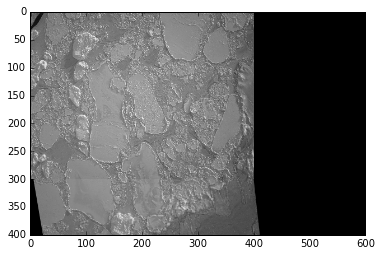

In [174]:

img1 = cv2.resize(img1o, (400,300))
imgt = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.resize(img2o, (400,300))
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

#cv2.imwrite('sift_keypoints.jpg',i
ph = -img1.shape[0]
pw = -img1.shape[1]
ftype = 'ORB'


img45 = rotate(imgt, 45).astype(np.uint8)
img90 = rotate(imgt, 90).astype(np.uint8)
img180 = rotate(imgt, 180).astype(np.uint8)


sift = cv2.SIFT()#

cimg = mosaic2imgs(imgt, img2, sift)
#keypoints45, descriptors45 = sift.detectAndCompute(img45, None)
#keypoints90, descriptors90 = sift.detectAndCompute(img90, None)
#keypoints180, descriptors180 = sift.detectAndCompute(img180, None)

plt.imshow(cimg)


In [168]:
matcher = cv2.DescriptorMatcher_create("BruteForce")
raw_matches = matcher.knnMatch(d, d1, 2)

In [126]:
m=raw_matches[0]
#if len(m) == 2 and m[0].distance < m[1].distance * min_ratio:
#            matches.append((m[0].trainIdx, m[0].queryIdx))
m[0].queryIdx        

0

In [ ]:
from skimage.feature.util import _mask_border_keypoints, DescriptorExtractor
class zernike(DescriptorExtractor):
    
    def __init__(self, descriptor_size=256, patch_size=49,
                  sigma=1, sample_seed=1):
        self.descriptor_size = descriptor_size
        self.patch_size = patch_size
        self.sigma = sigma
        self.sample_seed = sample_seed

        self.descriptors = None
        self.mask = None
    
    def extract(self, image, keypoints):
        patch_size = self.patch_size
        desc_size = self.descriptor_size
        random = np.random.RandomState()
        random.seed(self.sample_seed)
        samples = (patch_size / 5.0) * random.randn(desc_size * 8)
        samples = np.array(samples, dtype=np.int32)
        samples = samples[(samples < (patch_size // 2))
                          & (samples > - (patch_size - 2) // 2)]

        pos1 = samples[:desc_size * 2].reshape(desc_size, 2)
        pos2 = samples[desc_size * 2:desc_size * 4].reshape(desc_size, 2)
        
        pos1 = np.ascontiguousarray(pos1)
        pos2 = np.ascontiguousarray(pos2)
        self.mask = _mask_border_keypoints(image.shape, keypoints,
                                           patch_size // 2)
        keypoints = np.array(keypoints[self.mask, :], dtype=np.intp,
                             order='C', copy=False)
        self.descriptors = np.zeros((keypoints.shape[0], desc_size),
                                    dtype=bool, order='C')
        
        _zern_loop(image, self.descriptors.view(np.uint8), keypoints,
                    pos1, pos2)


In [ ]:
descriptor_extractor = ORB(n_keypoints=num_keypoints)

descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1= descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [ ]:
def _zern_loop(image, descriptors, keypoints, pos0, pos1):
    for p in range(pos0.shape[0]):
        pr0 = pos0[p, 0]
        pc0 = pos0[p, 1]
        pr1 = pos1[p, 0]
        pc1 = pos1[p, 1]
        for k in range(keypoints.shape[0]):
            kr = keypoints[k, 0]
            kc = keypoints[k, 1]
            if image[kr + pr0, kc + pc0] < image[kr + pr1, kc + pc1]:
                descriptors[k, p] = True

In [ ]:
from mahotas.features import zernike_moments

br1 = zernike()
#keypoints = corner_peaks(corner_harris(img1), min_distance=5)
keypoints1 = corner_peaks(corner_harris(img1, method='eps', eps=.001, sigma=3), min_distance=5)
br1.extract(img1, keypoints1)
descriptors1 = br1.descriptors
keypoints1 = keypoints1[br1.mask]

br2 = zernike()
#keypoints1 = corner_peaks(corner_harris(img2), min_distance=5)
keypoints2 = corner_peaks(corner_harris(img2, method='eps', eps=.001, sigma=3), min_distance=5)
br2.extract(img2, keypoints)
descriptors2 = br2.descriptors
keypoints2 = keypoints2[br2.mask]

In [ ]:
import cv2

In [ ]:
from scipy import ndimage

#rotation angle in degree
rotated = ndimage.rotate(img1, 45)

In [ ]:
plt.imshow(rotated)

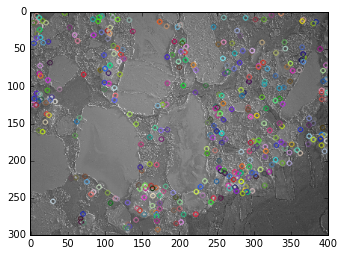

In [52]:

img = cv2.resize(img1o, (400,300))
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
sift = cv2.SIFT()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp)
plt.imshow(img)
#cv2.imwrite('sift_keypoints.jpg',img)

In [ ]:
kp

In [ ]:
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break